# SUPERMARKET SALES

Proyecto de análisis de Series Temporales y Forecast
-- Análisis Serie Temporal - Forecast --

Jose Luis Quintero García, abr2023

## Importación de librerías y carga de datos

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [130]:
ordenes = pd.read_csv("./ordenes.csv", parse_dates=["Order Date", "Ship Date"])
ordenes.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,City,Product ID,Sales,Quantity,Discount,Profit,Devolucion
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Henderson,FUR-BO-10001798,261.9600,2,0.00,41.9136,0
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Henderson,FUR-CH-10000454,731.9400,3,0.00,219.5820,0
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Los Angeles,OFF-LA-10000240,14.6200,2,0.00,6.8714,0
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Fort Lauderdale,FUR-TA-10000577,957.5775,5,0.45,-383.0310,0
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Fort Lauderdale,OFF-ST-10000760,22.3680,2,0.20,2.5164,0


In [131]:
# Quitamos los registros donde haya una devolución
ordenes = ordenes.loc[ordenes["Devolucion"]==0]

# Borramos la columna "devolucion", que ahora sobra
ordenes.drop(["Devolucion"], axis=1, inplace=True)

## Análisis

El trabajo a realizar es el siguiente:

1. Expondremos los datos de ventas globales y haremos un análisis de la serie temporal resultante, con datos de ventas por días.
2. Analizaremos si la serie es o no estacionaria y si presenta algún tipo de patrón de estacionalidad. 
3. Con ello determinaremos el mejor modelo para realizar un forecast de ventas durante el próximo mes.

In [132]:
ordenes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9194 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Order ID     9194 non-null   object        
 1   Order Date   9194 non-null   datetime64[ns]
 2   Ship Date    9194 non-null   datetime64[ns]
 3   Ship Mode    9194 non-null   object        
 4   Customer ID  9194 non-null   object        
 5   City         9194 non-null   object        
 6   Product ID   9194 non-null   object        
 7   Sales        9194 non-null   float64       
 8   Quantity     9194 non-null   int64         
 9   Discount     9194 non-null   float64       
 10  Profit       9194 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 861.9+ KB


In [133]:
# Vamos a agrupar los datos por fechas. Aunque perderemos las variables categóricas, no nos importa, porque lo que queremos analizar aquí
# son los datos de ventas o beneficio
ordenes = ordenes \
    .groupby("Order Date") \
    .aggregate({'Order ID': "count", \
                'Sales': "sum", \
                'Quantity': "sum", \
                'Profit': "sum" }) \
    .sort_values("Order Date", ascending=True)  

# Y ahora hacemos un resample para cambiar la frecuencia a mensual:
ordenes = ordenes.resample("M").asfreq()   # El valor "MS" nos agrupa valores inicio de cada mes
ordenes = ordenes.fillna(0)               # Ponemos 0 en los meses en los que no ha habido ventas
ordenes.head(10)

,Order ID,Sales,Quantity,Profit
Order Date,,,,
2014-01-31,1.0,290.666,2.0,3.4196
2014-02-28,0.0,0.000,0.0,0.0000
2014-03-31,9.0,1959.552,29.0,355.1097
2014-04-30,3.0,1048.740,13.0,276.4956
2014-05-31,2.0,773.700,6.0,230.9727
2014-06-30,8.0,739.624,38.0,249.5572
2014-07-31,0.0,0.000,0.0,0.0000
2014-08-31,1.0,92.520,9.0,18.5040
2014-09-30,6.0,987.532,26.0,119.4905


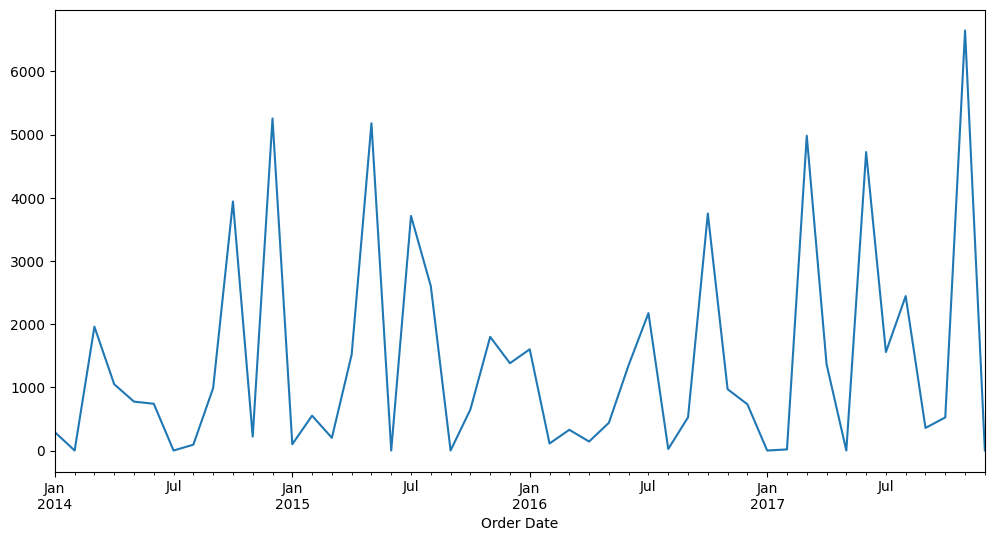

In [134]:
# Dibujamos la serie resultante en ventas
ordenes["Sales"].plot(figsize=(12,6));

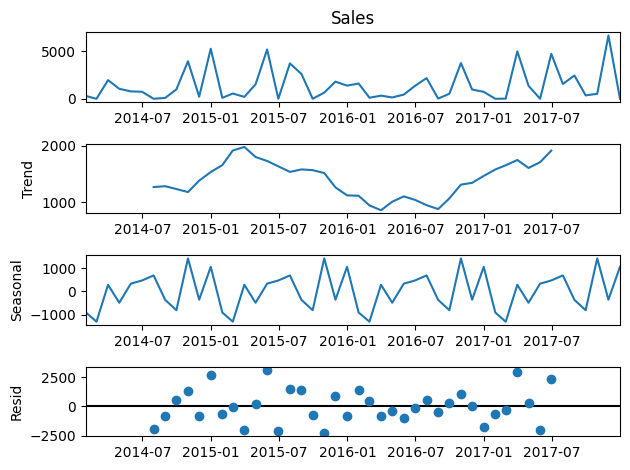

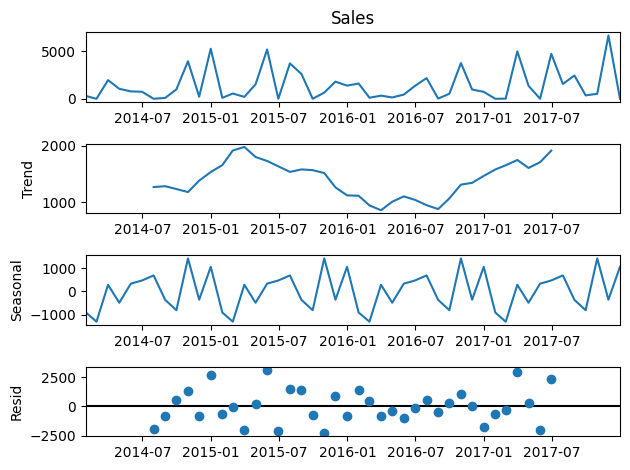

In [143]:
# Hacemos una descomposición de la estacionalidad
seasonal_decompose(ordenes["Sales"], model='additive').plot()